# News Headlines Sentiment

Use the news api to pull the latest news articles for stock and create a DataFrame of sentiment scores. 

In [102]:
# Initial imports
import os
from dotenv import load_dotenv
import pandas as pd
from newsapi import NewsApiClient
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
analyzer = SentimentIntensityAnalyzer()
load_dotenv()

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [103]:
# input stock ticker

ticker = 'BRK'

In [104]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/draganbogatic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [105]:
# Read your api key environment variable
api_key = os.getenv("NEWS_API_KEY")

In [106]:
# Create a newsapi client
newsapi = NewsApiClient(api_key=api_key)

In [107]:
# Fetch the stock news articles; put in the ticker symbol of the stock you need information about
stock_headlines = newsapi.get_everything(q=f'{ticker}', language='en', sort_by="relevancy", page_size=100)
stock_articles = stock_headlines["articles"]
stock_articles[0]

{'source': {'id': None, 'name': "Investor's Business Daily"},
 'author': "Investor's Business Daily",
 'title': 'How Buffett, Others Scored $80 Billion In Five-Day Stock Sell-Off',
 'description': "It's been a tough five days for most S&P 500 investors. But some fleet-footed investors are finding gains in rising S&P 500 sectors.",
 'url': 'https://www.investors.com/etfs-and-funds/sectors/sp500-how-investors-scored-billions-in-the-five-day-stock-sell-off/',
 'urlToImage': 'https://www.investors.com/wp-content/uploads/2017/07/RETIRE-MONEYLAST-071717-adobe.jpeg',
 'publishedAt': '2021-07-20T12:00:23Z',
 'content': "It's been a tough five days for most S&amp;P 500 investors. But some fleet-footed traders are finding gains in rising S&amp;P 500 sectors and stocks amid the sell-off.\r\nXNearly 80 of the stocks in th… [+5103 chars]"}

In [108]:
# Create the stock sentiment scores DataFrame
stock_sentiments = []

for article in stock_articles:
    try:
        text = article["content"]
        date = article["publishedAt"][:10]
        sentiment = analyzer.polarity_scores(text)
        compound = sentiment["compound"]
        pos = sentiment["pos"]
        neu = sentiment["neu"]
        neg = sentiment["neg"]
        
        stock_sentiments.append({
            "text": text,
            "date": date,
            "compound": compound,
            "positive": pos,
            "negative": neg,
            "neutral": neu
            
        })
        
    except AttributeError:
        pass
    
# Create DataFrame
stock_df = pd.DataFrame(stock_sentiments)

# Reorder DataFrame columns
cols = ["date", "text", "compound", "positive", "negative", "neutral"]
stock_df = stock_df[cols]

In [109]:
# Drop duplicates articles
stock_df.drop_duplicates(keep="first", inplace=True)
stock_df.iloc[:1]

,date,text,compound,positive,negative,neutral
0,2021-07-20,It's been a tough five days for most S&amp;P 5...,0.2263,0.063,0.04,0.897


In [110]:
# Describe the stock sentiment
stock_df.describe()

,compound,positive,negative,neutral
count,4.000000,4.000000,4.000000,4.000000
mean,0.420550,0.125500,0.036750,0.837750
std,0.256547,0.088425,0.026247,0.110693
min,0.202300,0.052000,0.000000,0.695000
25%,0.220300,0.060250,0.030000,0.782000
50%,0.368450,0.103500,0.042500,0.854000
75%,0.568700,0.168750,0.049250,0.909750
max,0.743000,0.243000,0.062000,0.948000


---

# Tokenizer

In this section, you will use NLTK and Python to tokenize the text for each stock. Be sure to:
1. Lowercase each word
2. Remove Punctuation
3. Remove Stopwords

In [111]:
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import regex
import re

In [112]:
stock_text_df = stock_df['text'].astype('str')
stock_text_df

0    It's been a tough five days for most S&amp;P 5...
1    New York (CNN Business)Berkshire Hathaway vice...
2    The Dow Jones Industrial Average was moved hig...
3    Growth stocks have outrun their value stock co...
Name: text, dtype: object

In [113]:
# Complete the tokenizer function
def tokenizer(text):

    """Tokenizes text."""

    # Create a list of the words
    words = [word_tokenize(sentence) for sentence in text]

    # Remove punctuation using regex; Remove any non-string character and replace with empty space
    regex = re.compile("[^a-zA-Z ]")
    re_clean = regex.sub('', text)
    words_clean = word_tokenize(re_clean)
   
   # Remove the stop words
    sw = set(stopwords.words('english'))
    first_pass = [word for word in words_clean if word not in sw]

    # Define additional stopwords
    sw_addon = {'char', 'chars' 'la', 'im','volod', 'drin', 'wa', 'ha'}
    second_pass = [word.lower() for word in words_clean if word.lower() not in sw.union(sw_addon)] 

    # Lemmatize Words into root words; convert the words to lowercase
    lemmatizer = WordNetLemmatizer()
    lem = [lemmatizer.lemmatize(word) for word in words_clean]
    tokens = [word.lower() for word in lem if word.lower() not in sw.union(sw_addon)] 
  
    return tokens

In [114]:
# Tokenizing article in the first row of the "text" column
tokenizer(stock_text_df[0])

['tough',
 'five',
 'day',
 'sampp',
 'investor',
 'fleetfooted',
 'trader',
 'finding',
 'gain',
 'rising',
 'sampp',
 'sector',
 'stock',
 'amid',
 'selloffxnearly',
 'stock',
 'th']

In [115]:
# Create for-loop to iterate through rows in the "text" column 
stock_tokens = []
for row in stock_text_df:
    token = tokenizer(row)
    stock_tokens.append(token)

    print(stock_tokens) 

[['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp', 'sector', 'stock', 'amid', 'selloffxnearly', 'stock', 'th']]
[['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp', 'sector', 'stock', 'amid', 'selloffxnearly', 'stock', 'th'], ['new', 'york', 'cnn', 'businessberkshire', 'hathaway', 'vice', 'chairman', 'charlie', 'munger', 'praised', 'chinese', 'government', 'silencing', 'alibabas', 'jack', 'recent', 'interview', 'adding', 'wish', 'us', 'financial', 'regulat']]
[['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp', 'sector', 'stock', 'amid', 'selloffxnearly', 'stock', 'th'], ['new', 'york', 'cnn', 'businessberkshire', 'hathaway', 'vice', 'chairman', 'charlie', 'munger', 'praised', 'chinese', 'government', 'silencing', 'alibabas', 'jack', 'recent', 'interview', 'adding', 'wish', 'us', 'financial', 'regulat'], ['dow', 'jo

In [116]:
# Create a new tokens column for the stock
stock_df['btc_token'] = stock_tokens
stock_df.head()

,date,text,compound,positive,negative,neutral,btc_token
0,2021-07-20,It's been a tough five days for most S&amp;P 5...,0.2263,0.063,0.040,0.897,"[tough, five, day, sampp, investor, fleetfoote..."
1,2021-06-30,New York (CNN Business)Berkshire Hathaway vice...,0.5106,0.144,0.045,0.811,"[new, york, cnn, businessberkshire, hathaway, ..."
2,2021-07-07,The Dow Jones Industrial Average was moved hig...,0.2023,0.052,0.000,0.948,"[dow, jones, industrial, average, moved, highe..."
3,2021-07-21,Growth stocks have outrun their value stock co...,0.7430,0.243,0.062,0.695,"[growth, stock, outrun, value, stock, counterp..."


---

# NGrams and Frequency Analysis

In this section you will look at the ngrams and word frequency for each stock. 

1. Use NLTK to produce the n-grams for N = 2. 
2. List the top 10 words for each stock. 

In [117]:
from collections import Counter
from nltk import ngrams

In [118]:
# Create one list of tokens from list of tokens in each row
stock_processed = []
for row in stock_df['btc_token']:
    for item in row:
        stock_processed.append(item)
        print(stock_processed)

['tough']
['tough', 'five']
['tough', 'five', 'day']
['tough', 'five', 'day', 'sampp']
['tough', 'five', 'day', 'sampp', 'investor']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp', 'sector']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp', 'sector', 'stock']
['tough', 'five', 'day', 'sampp', 'investor', 'fleetfooted', 'trader', 'finding', 'gain', 'rising', 'sampp'

In [119]:
# Generate the Bitcoin N-grams where N=2
stock_bigram = Counter(ngrams(stock_processed, n=2))
print(dict(stock_bigram))


{('tough', 'five'): 1, ('five', 'day'): 1, ('day', 'sampp'): 1, ('sampp', 'investor'): 1, ('investor', 'fleetfooted'): 1, ('fleetfooted', 'trader'): 1, ('trader', 'finding'): 1, ('finding', 'gain'): 1, ('gain', 'rising'): 1, ('rising', 'sampp'): 1, ('sampp', 'sector'): 1, ('sector', 'stock'): 1, ('stock', 'amid'): 1, ('amid', 'selloffxnearly'): 1, ('selloffxnearly', 'stock'): 1, ('stock', 'th'): 1, ('th', 'new'): 1, ('new', 'york'): 1, ('york', 'cnn'): 1, ('cnn', 'businessberkshire'): 1, ('businessberkshire', 'hathaway'): 1, ('hathaway', 'vice'): 1, ('vice', 'chairman'): 1, ('chairman', 'charlie'): 1, ('charlie', 'munger'): 1, ('munger', 'praised'): 1, ('praised', 'chinese'): 1, ('chinese', 'government'): 1, ('government', 'silencing'): 1, ('silencing', 'alibabas'): 1, ('alibabas', 'jack'): 1, ('jack', 'recent'): 1, ('recent', 'interview'): 1, ('interview', 'adding'): 1, ('adding', 'wish'): 1, ('wish', 'us'): 1, ('us', 'financial'): 1, ('financial', 'regulat'): 1, ('regulat', 'dow'): 1

In [120]:
# Print 20 most common stock bigrams
print(dict(stock_bigram.most_common(20)))

{('tough', 'five'): 1, ('five', 'day'): 1, ('day', 'sampp'): 1, ('sampp', 'investor'): 1, ('investor', 'fleetfooted'): 1, ('fleetfooted', 'trader'): 1, ('trader', 'finding'): 1, ('finding', 'gain'): 1, ('gain', 'rising'): 1, ('rising', 'sampp'): 1, ('sampp', 'sector'): 1, ('sector', 'stock'): 1, ('stock', 'amid'): 1, ('amid', 'selloffxnearly'): 1, ('selloffxnearly', 'stock'): 1, ('stock', 'th'): 1, ('th', 'new'): 1, ('new', 'york'): 1, ('york', 'cnn'): 1, ('cnn', 'businessberkshire'): 1}


In [121]:
# Use the token_count function to generate the top 10 words from each stock
def token_count(tokens, N=10):
    """Returns the top N tokens from the frequency count"""
    return Counter(tokens).most_common(N)

In [122]:
# Get the top 10 words for the stock
stock_top_ten = token_count(stock_processed)
stock_top_ten

[('stock', 5),
 ('value', 3),
 ('sampp', 2),
 ('investor', 2),
 ('new', 2),
 ('year', 2),
 ('tough', 1),
 ('five', 1),
 ('day', 1),
 ('fleetfooted', 1)]

# Word Clouds

In this section, you will generate word clouds for the stock to summarize the news for each stock

In [123]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [20.0, 10.0]

Text(0.5, 1.0, 'Word Cloud')

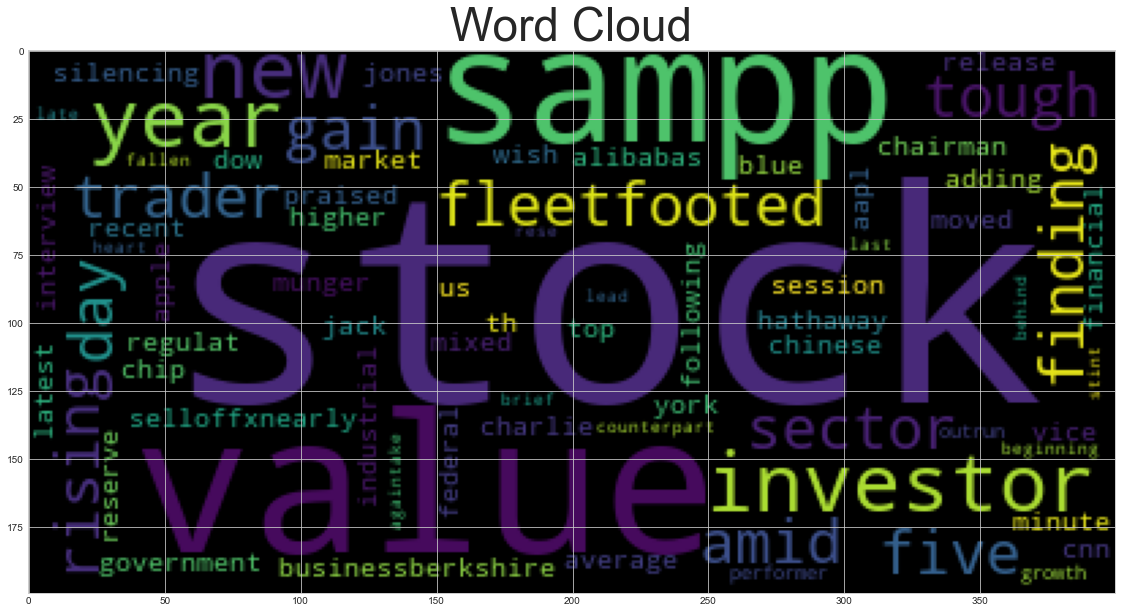

In [124]:
# Generate the stock word cloud
wc = WordCloud().generate(' '.join(stock_processed))
plt.imshow(wc)

# Add title to a Word Cloud 
plt.title("Word Cloud", fontdict={"fontsize":46})

# Named Entity Recognition

In this section, you will build a named entity recognition model for stock and visualize the tags using SpaCy.

In [125]:
import spacy
from spacy import displacy

In [126]:
# Load the spaCy model
nlp = spacy.load('en_core_web_sm')

## Stock NER

In [127]:
# Concatenate all of the stock text together
stock_joined = " ".join(stock_processed)

In [128]:
# Run the NER processor on all of the text
doc_stock = nlp(stock_joined)

# Add a title to the document
doc_stock.user_data["title"] = "Stock NER"

In [129]:
# Render the visualization
displacy.render(doc_stock, style='ent')

In [130]:
# List all Entities
print([ent.text for ent in doc_stock.ents])

['five day', 'new york', 'cnn', 'charlie munger', 'chinese', 'late last year']


---